In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import IPython.display as display
from PIL import Image
import functools

In [2]:
def load_image(img_path):
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]  # creates another dimension (1, ..., ..., 3)
    
    return img

In [3]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        
    plt.imshow(image)
    if title:
        plt.title(title)

In [29]:
content_path = "images/turtle.jpg"
style_path = "images/starry_night.jpg"

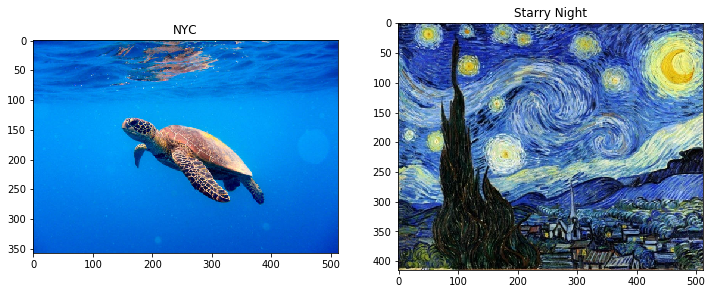

In [30]:
content_image = load_image(content_path)
style_image = load_image(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, title="NYC")

plt.subplot(1, 2, 2)
imshow(style_image, title="Starry Night")

In [6]:
def load_and_preprocess(image_path):
    image = load_image(image_path)
    image = keras.applications.vgg19.preprocess_input(image*255.0)
    return image

In [7]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]  # access the first matrix if (1, ..., ..., ...)
    return Image.fromarray(tensor)

In [8]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
               "block2_conv1",
               "block3_conv1",
               "block4_conv1",
               "block5_conv1"]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [9]:
def get_model():
    vgg = keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    
    return keras.models.Model(vgg.input, model_outputs)

In [10]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [11]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [12]:
def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [13]:
def get_feature_representations(model, content_path, style_path):
    content_image = load_image(content_path)
    style_image = load_image(style_path)
    
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    
    style_features = [style_output[0] for style_output in style_outputs[:num_style_layers]]
    content_features = [content_output[0] for content_output in content_outputs[num_style_layers:]]
    
    return style_features, content_features

In [14]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    
    model_outputs = model(init_image)
    
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_score = 0
    content_score = 0
    
    weight_per_style_layer = 1.0 / num_style_layers
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style[0])
    
    weight_per_content_layer = 1.0 / num_content_layers
    for target_style, comb_style in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * get_content_loss(comb_style[0], target_style[0])
    
    style_score *= style_weight
    content_score *= content_weight
    
    loss = style_score + content_score
    return loss, style_score, content_score

In [15]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [33]:
def run_style_transfer(content_path, style_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False
        
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    init_image = load_image(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    
    opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    iter_count = 1
    
    best_loss, best_img = float('inf'), None
    
    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }
    
    num_rows = 2
    num_cols = 5
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        
        opt.apply_gradients([(grads, init_image)])
#         clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(init_image)
        
        if loss < best_loss:
            best_loss = loss
            best_img = tensor_to_image(init_image)
            
        plot_img = tensor_to_image(init_image)
        
        display.clear_output(wait=True)
        display.display(plot_img)
        
        print(f'Total Loss: {loss}, Best Loss: {best_loss}')
    
    return best_img, best_loss

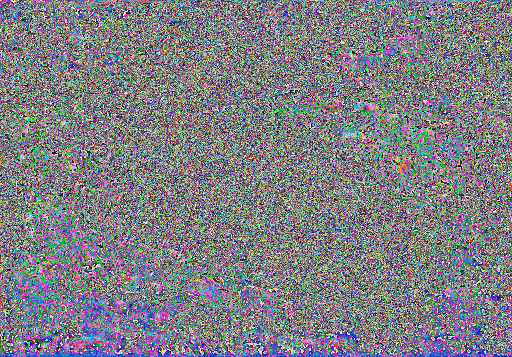

Total Loss: 631.14990234375, Best Loss: 631.14990234375


In [34]:
best_img, best_loss = run_style_transfer(content_path, style_path, num_iterations=10, content_weight=1e3, style_weight=1e-4)

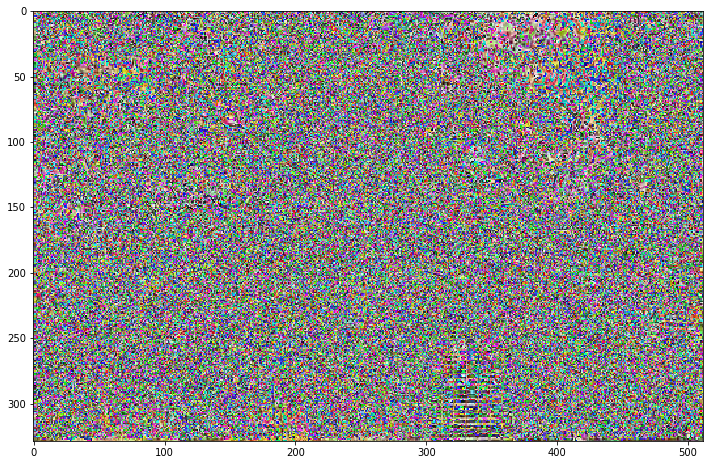

In [28]:
plt.imshow(best_img)